In [1]:
import numpy as np
import torch
import random
import pickle
import pandas as pd

import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from datasets import load_dataset


### https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
if torch.cuda.is_available():
    dev = torch.cuda.current_device()
    torch.cuda.device(dev)
    print("Using", torch.cuda.get_device_name(0))
else:
    torch.device("cpu")

Using GeForce GTX 1060


### Processing the data [DailyDialog] to make it task specific

In [25]:
dataset = load_dataset('imdb')
print(dataset)

Reusing dataset imdb (/home/sambit/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [26]:
temp = dataset["test"].train_test_split(test_size=0.5)
dataset["test"] = temp["test"]
dataset["validation"] = temp["train"]
del dataset["unsupervised"]

Loading cached split indices for dataset at /home/sambit/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3/cache-2c6700c05908a637.arrow and /home/sambit/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3/cache-6c009111a19e094d.arrow


In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
})

In [28]:
dataset['train'][:2]

OrderedDict([('label', [1, 1]),
             ('text',
              ['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
               'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan 

In [39]:
def split_data_into_lists(mode):
    global dataset
    temp_data = dataset[mode]
    rows = []
    
    for i, d in enumerate(temp_data):      
        rows.append([d["text"], d["label"]])
            
    df = pd.DataFrame(data=rows, columns=['text', 'label'])
    df.to_csv("data/imdb/csv/"+mode+".csv", index=False)

In [40]:
### UNCOMMENT IF THE DATA SPLITTING PROCESS IS CHANGED
split_data_into_lists("test")
split_data_into_lists("validation")
split_data_into_lists("train")

### Pre-processing for BERT

In [62]:
ohe_emo = OneHotEncoder(handle_unknown='ignore')
X = [[0], [1]]
ohe_emo.fit(X)

# { 0: negative, 1: positive}

print(ohe_emo.transform([[4]]).toarray())

[[0. 0.]]


In [48]:
def load_csv(mode):
    df = pd.read_csv("data/imdb/csv/"+mode+".csv")
    return df

# Get the dialog from the generated dataframe
def get_cell(df, row, column_name):
    return df.loc[df.index[row], column_name]

### Loading and tokenizing the data

In [49]:
train = load_csv("train")
val = load_csv("validation")
test = load_csv("test")

In [51]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentence = get_cell(train, 0, "text")
print("Original:", sentence)
tokenized = tokenizer.tokenize(sentence)
print("Tokenised:", tokenized)
tokenided = tokenizer.convert_tokens_to_ids(tokenized)
print("Token ID:", tokenided)

Original: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
Tokenised: ['bro', '##m', '##well', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life'

In [63]:
# Tokenize the current and previous dialog for a specific row
# Can return emotion data or act data depending on "mode"

max_previous_length = 0
max_current_length = 0

def get_processed_row(df, row, mode="emo"):
    global  max_previous_length
    global max_current_length
    
    sentence = get_cell(df, row, "text")
    tokenized = tokenizer.tokenize(sentence)
    tokenided_c = tokenizer.convert_tokens_to_ids(tokenized)
    
    if len(tokenided_c) > max_current_length:
        max_current_length = len(tokenided_c)
    
    label = ohe_emo.transform([[get_cell(df, row, "label")]]).toarray().flatten().tolist()
    
    return tokenided_c, label


# Save the sentence with one hot encoded labels (can be used with encode_plus)

def get_unprocessed_row(df, row):
    global  max_previous_length
    global max_current_length
    
    sentence_c = get_cell(df, row, "text")
    
    label = get_cell(df, row, "label")

    
    return sentence_c, label

In [64]:
### Save tokenised data

def save_to_pkl(data, mode, dataset="emo"):
    with open("data/imdb/pkl/"+mode+"_"+dataset+".pkl", "wb") as f:
        pickle.dump(data, f)

def save_to_sent(data, mode, dataset="emo"):
    with open("data/imdb/sent/"+mode+"_"+dataset+".pkl", "wb") as f:
        pickle.dump(data, f)

### Generating PKLs for Emotion Data & Act Data (Sentences are tokenised)

In [69]:
import matplotlib.pyplot as plt

def plot_label_dist(label_dict):
    cols = label_dict.keys()
    vals = label_dict.values()
    
    print(label_dict)
    
    plt.bar(cols, vals)
    plt.show()

def get_label_counts(data):
    label_count = {}
    for d in data:
#         if d[1] == 0:
#             continue
        try:
            label_count[d[1]] += 1
        except KeyError:
            label_count[d[1]] = 1
    return label_count

In [66]:
train_data = []
for i in range(train.shape[0]):
    train_data.append(get_processed_row(train, i))
    
save_to_pkl(train_data, "train")

val_data = []
for i in range(val.shape[0]):
    val_data.append(get_processed_row(val, i))
save_to_pkl(val_data, "val")

test_data = []
for i in range(test.shape[0]):
    test_data.append(get_processed_row(test, i))
save_to_pkl(test_data, "test")


# train_data = []
# for i in range(train.shape[0]):
#     train_data.append(get_processed_row(train, i, "act"))
# save_to_pkl(train_data, "train", "act")

# val_data = []
# for i in range(val.shape[0]):
#     val_data.append(get_processed_row(val, i, "act"))
# save_to_pkl(val_data, "val", "act")

# test_data = []
# for i in range(test.shape[0]):
#     test_data.append(get_processed_row(test, i, "act"))
# save_to_pkl(test_data, "test", "act")

### Generating PKLs for Sentences

In [67]:
# Emo data

train_data = []
for i in range(train.shape[0]):
    train_data.append(get_unprocessed_row(train, i))
save_to_sent(train_data, "train")

val_data = []
for i in range(val.shape[0]):
    val_data.append(get_unprocessed_row(val, i))
save_to_sent(val_data, "val")

test_data = []
for i in range(test.shape[0]):
    test_data.append(get_unprocessed_row(test, i))
save_to_sent(test_data, "test")


# # Act data

# train_data = []
# for i in range(train.shape[0]):
#     train_data.append(get_unprocessed_row(train, i, "act"))
# save_to_sent(train_data, "train", "act")

# val_data = []
# for i in range(val.shape[0]):
#     val_data.append(get_unprocessed_row(val, i, "act"))
# save_to_sent(val_data, "val", "act")

# test_data = []
# for i in range(test.shape[0]):
#     test_data.append(get_unprocessed_row(test, i, "act"))
# save_to_sent(test_data, "test", "act")

{1: 12500, 0: 12500}


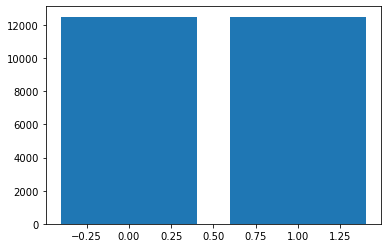

{1: 6233, 0: 6267}


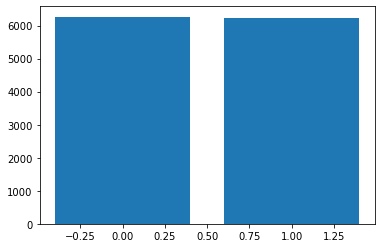

{0: 6233, 1: 6267}


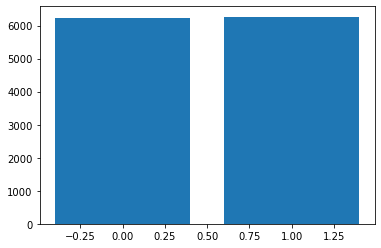

In [70]:
t1 = get_label_counts(train_data)
plot_label_dist(t1)

t2 = get_label_counts(val_data)
plot_label_dist(t2)

t3 = get_label_counts(test_data)
plot_label_dist(t3)